<a href="https://colab.research.google.com/github/ozturkgizem/Agriculture/blob/main/feng%26dp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("Crop_recommendation.csv")

**FEATURE ENG & DATA PROCESSING**

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [7]:
def crop_recommendation_data_prep(dataframe):

    dataframe = df
    dataframe.columns = [col.upper() for col in dataframe.columns]

    print(df.describe().T)
    ##1: CROP SUITABILITY INDICES

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    def crop_suitability_indices(crop, col):
        low_limit, up_limit = outlier_thresholds(dataframe[dataframe["LABEL"] == crop], col)
        dataframe.loc[(dataframe["LABEL"] == crop) & (dataframe[col] >= low_limit) & (dataframe[col] <= up_limit), f"NEW_{col.upper()}_OPTIMAL"] = 1
        dataframe.loc[(dataframe["LABEL"] == crop) & (dataframe[col] < low_limit) | (dataframe[col] > up_limit), f"NEW_{col.upper()}_OPTIMAL"] = 0

    for crop in dataframe["LABEL"].unique():
        for col in num_cols:
            crop_suitability_indices(crop, col)

    ##2: NUTRIENT BALANCE INDEX (NBI)

    dataframe["N/K"]= dataframe["N"] / dataframe["K"]
    dataframe["N/P"] = dataframe["N"] / dataframe["P"]
    dataframe["P/K"] = dataframe["P"] / dataframe["K"]

    ratios = ["N/K","N/P","P/K"]
    dataframe[ratios] = MinMaxScaler().fit_transform(dataframe[ratios])

    dataframe["NEW_NBI"] = np.sqrt(dataframe["N/K"] * dataframe["N/P"] * dataframe["P/K"])
    dataframe.drop(ratios, axis=1, inplace=True)

    ##3: CATEGORIZE BY PH LEVELS

    dataframe.loc[dataframe["PH"] < 7, "NEW_PH_CAT"] = "acidic"
    dataframe.loc[dataframe["PH"] > 7, "NEW_PH_CAT"] = "alkaline"
    dataframe.loc[dataframe["PH"] == 7, "NEW_PH_CAT"] = "neutral"
    dataframe.loc[(dataframe["PH"] >= 5.5) & (dataframe["PH"] <= 6.5), "NEW_PH_CAT"] = "optimal"

    ##4: CATEGORIZE BY RAINFALL
    #sns.catplot(data=df, x='label', y="rainfall", kind='box', height=10, aspect=22/8)
    #plt.title(f"{col}", size=12)
    #plt.xticks(rotation='vertical')
    #plt.show()

    #df["rainfall"].describe([0.10,0.20,0.30,0.33,0.40,0.50,0.60,0.66,0.70,0.75,0.80,0.90,0.99])

    dataframe["NEW_RAINFALL_CAT"] = pd.cut(x=dataframe["RAINFALL"], bins=[0, 44, 71, 111, 188, 300], labels=["extreme_low", "low", "medium", "high", "extreme_high"])

    print("4")
    print(dataframe.head(5))


    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    ##5. ONE HOT ENCODER
    def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
        dff = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
        return dff


    df.columns = [col.upper() for col in df.columns]
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=6, car_th=20)
    cat_cols = [col for col in cat_cols if "LABEL" not in col]

    print()
    print(cat_cols)
    print(num_cols)
    print(cat_but_car)
    print()

    dff = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=6, car_th=20)
    cat_cols = [col for col in cat_cols if "LABEL" not in col]

    print(cat_cols)
    print(num_cols)
    print(cat_but_car)

    X_scaled = StandardScaler().fit_transform(dff[num_cols])
    dff[num_cols] = pd.DataFrame(X_scaled, columns=dff[num_cols].columns)

    y = LabelEncoder().fit_transform(dff["LABEL"])
    X = dff.drop(["LABEL"], axis=1)

    return X, y

In [16]:
X, y = crop_recommendation_data_prep(df)

                           count    mean    std    min    25%    50%     75%     max
N                       2200.000  50.552 36.917  0.000 21.000 37.000  84.250 140.000
P                       2200.000  53.363 32.986  5.000 28.000 51.000  68.000 145.000
K                       2200.000  48.149 50.648  5.000 20.000 32.000  49.000 205.000
TEMPERATURE             2200.000  25.616  5.064  8.826 22.769 25.599  28.562  43.675
HUMIDITY                2200.000  71.482 22.264 14.258 60.262 80.473  89.949  99.982
PH                      2200.000   6.469  0.774  3.505  5.972  6.425   6.924   9.935
RAINFALL                2200.000 103.464 54.958 20.211 64.552 94.868 124.268 298.560
NEW_N_OPTIMAL           2200.000   0.871  0.335  0.000  1.000  1.000   1.000   1.000
NEW_P_OPTIMAL           2200.000   0.685  0.464  0.000  0.000  1.000   1.000   1.000
NEW_K_OPTIMAL           2200.000   0.569  0.495  0.000  0.000  1.000   1.000   1.000
NEW_TEMPERATURE_OPTIMAL 2200.000   0.710  0.454  0.000  0.000  1.

In [9]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [ ]:
base_models(X,y)

In [14]:
y_prob = log_model.predict_proba(X)
roc_auc = roc_auc_score(y ,y_prob, multi_class='ovr')
print(roc_auc)

0.9999584415584415


In [17]:
log_model = LogisticRegression().fit(X, y)
y_pred = log_model.predict(X)

In [20]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

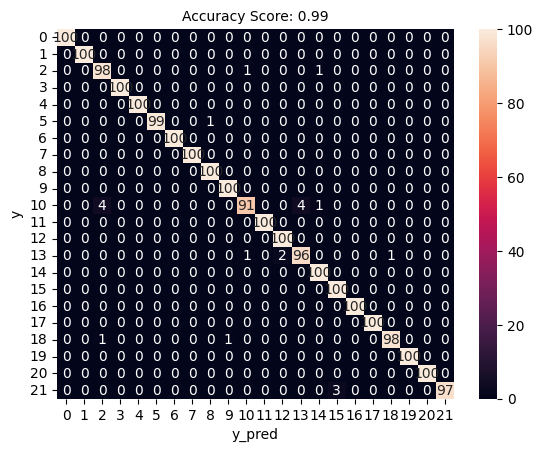

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.95      0.98      0.97       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      0.99      0.99       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       0.99      1.00      1.00       100
           9       0.99      1.00      1.00       100
          10       0.98      0.91      0.94       100
          11       1.00      1.00      1.00       100
          12       0.98      1.00      0.99       100
          13       0.96      0.96      0.96       100
          14       0.98      1.00      0.99       100
          15       0.97      1.00      0.99       100
          16       1.00      1.00      1.00       100
          17       1.00    

In [25]:
plot_confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)